In [48]:
import json
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

import nibabel as nib

import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf

from time import time

import typing
import pynufft

import pydicom

from skimage.transform import resize

sys.path.append(os.path.join(os.getcwd(), "CG-SENSE"))
from cg_sense_new_version import * 

In [49]:
path_to_summer = os.path.join("/data_network/summer_projects", os.environ["USER"], "Current/2023_MRF_Collab")

# Visualisation des DICOMS

Le DICOM a la forme (2600, 100, 100)


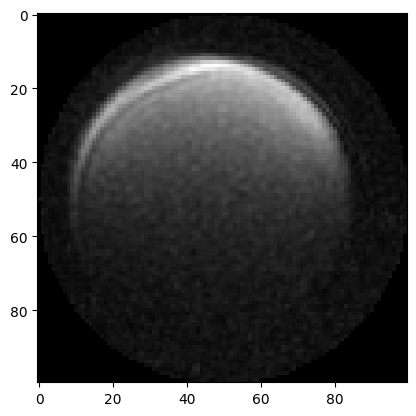

In [51]:
dicom = os.path.join(path_to_summer, 'Daniil/RawDataBruker/49/pdata/1/dicom/MRF_test_MRF_test_RefProtocol_E49_P1_EnIm1.dcm')

ds = pydicom.dcmread(dicom)

print(f"Le DICOM a la forme {ds.pixel_array.shape}")
plt.imshow(ds.pixel_array[0,:,:], cmap=plt.cm.gray)

# Chargement des données

In [56]:
path_acq = os.path.join(path_to_summer,'Daniil/RawDataBruker/49/')
acq_raw = np.fromfile(os.path.join(path_acq,'rawdata.job0'), dtype=np.int32)

path_coil_sensitivity =os.path.join(path_to_summer, 'Lila/94_coil_sensitivity.npy')
coil_sens = np.load(path_coil_sensitivity)

path_traj = os.path.join(path_acq,'traj')
traj = np.fromfile(path_traj, dtype=np.float64)
traj = traj.reshape(-1, 2)

k_space = np.zeros((4,260,4985), dtype=complex)

NbTotal = ds.pixel_array.shape[0]

for frame in range (1,261):
    for coil in range(4): 
        ksp_coil_frame = acq_raw[ (frame-1) * acq_raw.shape[0]//NbTotal + coil*acq_raw.shape[0]//NbTotal//4 : (frame-1) * acq_raw.shape[0]//NbTotal + (coil+1)*acq_raw.shape[0]//NbTotal//4]
        ksp_coil_frame = ksp_coil_frame[:-55*2]
        k_space[coil,frame-1,:] = 1j*ksp_coil_frame[0::2] +  ksp_coil_frame[1::2]

Le k-space final est en complex128 et à la forme (4, 260, 4985)


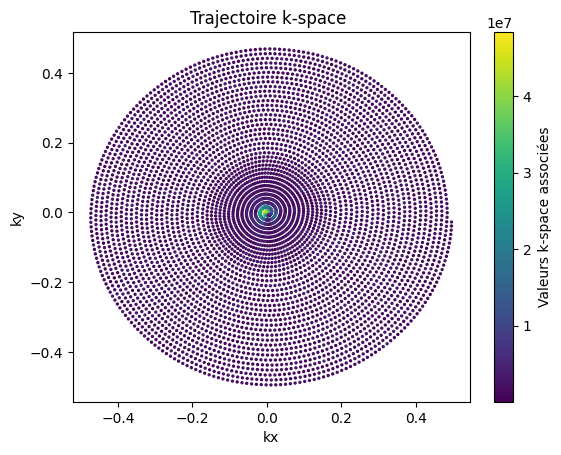

In [66]:
print(f"Le k-space final est en {k_space.dtype} et à la forme {k_space.shape}")

sc = plt.scatter(traj[:,0], traj[:,1], c=np.abs(k_space[0,0,:]), cmap='viridis',s=2)
plt.colorbar(sc, label="Valeurs k-space associées")
plt.xlabel("kx")
plt.ylabel("ky")
plt.title("Trajectoire k-space ")
plt.show()


# Mise en forme des données pour CG-SENSE

La trajectoire est normalisée entre -pi et pi et doit être de la forme (260, nb_points, 2).

Les cartes de sensibilités des coils doivent être de la forme (4, 100, 200) pour 4 coils et une image de taille (100,100).

Le k space doit avoir la forme (260, 4, nb_points).

In [60]:
traj_norma = traj * ( np.pi / np.max(np.abs(traj)))
traj_norma = np.repeat(traj_norma[np.newaxis,:, :], 260, axis=0)
traj_tf = tf.convert_to_tensor(traj_norma)
traj_tf = tf.cast(traj_tf, tf.float32)

real_resized = resize(np.real(coil_sens), (4,100, 100), preserve_range=True)
imag_resized = resize(np.imag(coil_sens), (4,100, 100), preserve_range=True)
resized_coil = real_resized + 1j * imag_resized
coil_sens_tf =  tf.convert_to_tensor(resized_coil, dtype = tf.complex64)

k_space_raw = np.transpose(k_space,(1,0,2))
k_space_tf = tf.convert_to_tensor(k_space_raw, dtype = tf.complex64)

# Reconstruction avec CG-SENSE

Le seul paramètre à fixer et le nombre maximum d'itérations. Il faut faire des tests pour qu'il ne soit ni trop bas ni trop haut (souvent entre 60 et 100). La fonction reconstruct_lstsq provient de Tensorflow-MRI : https://mrphys.github.io/tensorflow-mri/tutorials/recon/cg_sense/

In [69]:
cg_sense = reconstruct_lstsq(k_space_tf, image_shape=[100, 100], sensitivities=coil_sens_tf, trajectory=traj_tf, optimizer='cg', optimizer_kwargs={'max_iterations':2})

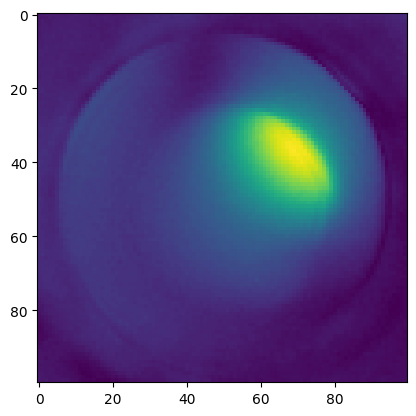

In [70]:
plt.imshow(np.abs(cg_sense[0,:,:]))